# MNIST digits classification with TensorFlow 2

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
print("We're using TF", tf.__version__)


We're using TF 2.0.0


# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train [shape (60000, 28, 28)] sample patch:
 [[  0  76 246 252 112]
 [  0  85 252 230  25]
 [  0  85 252 223   0]
 [  0  85 252 145   0]
 [  0  86 253 225   0]]
A closeup of a sample patch:


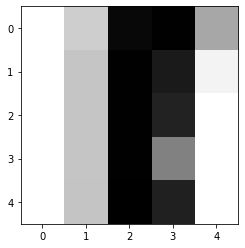

And the whole sample:


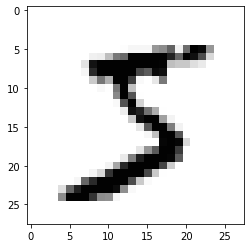

y_train [shape (60000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [3]:
# X contains rgb values divided by 255
print("x_train [shape %s] sample patch:\n" % (str(x_train.shape)), x_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(x_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(x_train[0], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])


In [4]:
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.


# Linear model

Our aim is to train a linear classifier $\vec{x} \rightarrow y$ with SGD (or other optimizers) using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{w_k} \cdot \vec{x} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if} \; x \; \text{is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

For our model, we can assume that $\vec{x}$ is a flattened vector coming from a digit image and $\vec{w_k}$ is a row from a weight matrix.

<img src="images/linear_classifier.png" style="width:70%">

When labels are represented by **one-hot vectors**, use the TensorFlow loss function 
```python
tf.keras.losses.CategoricalCrossentropy .
```
When labels are represented by **integers** (as in the above picture), use 
```python
tf.keras.losses.SparseCategoricalCrossentropy
```
instead.

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation='softmax')])
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 47us/sample - loss: 1.6525 - accuracy: 0.8639
Epoch 2/10
60000/60000 [==============================] - 2s 39us/sample - loss: 1.5692 - accuracy: 0.9120
Epoch 3/10
60000/60000 [==============================] - 2s 39us/sample - loss: 1.5568 - accuracy: 0.9191
Epoch 4/10
60000/60000 [==============================] - 2s 39us/sample - loss: 1.5500 - accuracy: 0.9232
Epoch 5/10
60000/60000 [==============================] - 2s 39us

In [7]:
# Compare some predicted digits with the actual digits 
predictions = model.predict_classes(x_test)
print(predictions[:10])
print(y_test[:10])


[7 2 1 0 4 1 4 9 6 9]
[7 2 1 0 4 1 4 9 5 9]


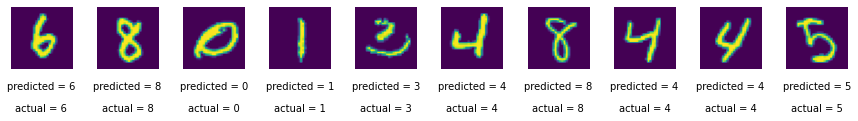

In [8]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx] 
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'predicted = ' + str(predictions[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'actual = ' + str(y_test[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)


# MLP with hidden layers

We can easily build a MultiLayer Perceptron using TensorFlow's dense layer construct:
```python
tf.keras.layers.Dense(inputs, 256, activation=tf.nn.sigmoid) .
```
We now define and train a neural network with 2 hidden layers.


In [9]:
mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(256, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(10)])


In [10]:
mlp_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


In [11]:
mlp_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
mlp_model.fit(x_train, y_train, epochs=10)


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.3640 - accuracy: 0.8962
Epoch 2/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1508 - accuracy: 0.9545
Epoch 3/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.1008 - accuracy: 0.9692
Epoch 4/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0718 - accuracy: 0.9773
Epoch 5/10
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0529 - accuracy: 0.9829
Epoch 6/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0400 - accuracy: 0.9875
Epoch 7/10
60000/60000 [==============================] - 4s 67us/sample - loss: 0.0304 - accuracy: 0.9903
Epoch 8/10
60000/60000 [==============================] - 4s 65us/sample - loss: 0.0241 - accuracy: 0.9925
Epoch 9/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.0186 - accuracy: 0.9941
Epoch 10/10
60

In [12]:
predictions = mlp_model.predict_classes(x_test)
print(y_test[:10])
print(predictions[:10])


[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 5 9]


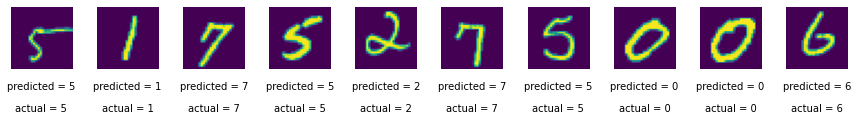

In [13]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx] 
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'predicted = ' + str(predictions[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'actual = ' + str(y_test[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)
